# Horizontal Fourth-Order Diffusion Demo

This notebook demonstrates some of the basic elements of GT4Py, and how different backends integrate seamlessly into the Python development environment.

In [1]:
import copy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import gt4py
from gt4py import gtscript

## Chose backend

The backend options include:
* "debug": generates pure Python loops
* "numpy": parallel axes use numpy slicing operations for "parallel" computation
* "gtx86": generates GridTools C++ code and compiles for an x86 processor
* "gtcuda": generates GridTools C++ code and compiles for a NVIDIA GPU

In [2]:
backend = "numpy"

## Define computation (horizontal 4th-order diffusion)

The DSL frontend allows us to specifiy the numerical equations we want to solve. Here, we would like to solve the horizontal 4th-order hyperdiffusion equation in three dimensions, given by

$$
\begin{eqnarray}
\frac{\partial T}{\partial t} = \alpha \nabla_h^4 T = \alpha \nabla_h^2 \left( \nabla_h^2 T \right)
\end{eqnarray}
$$

where T is Temperature and $\alpha$ is the diffusion coefficient. We discretize the horizontal Laplacian on a regular Cartesian grid using

$$
\begin{eqnarray}
\tilde{\nabla}_h^2 T_{i,j,k} = \frac{T_{i-1,j,k} + T_{i+1,j,k} + T_{i,j-1,k} + T_{i,j+1,k} - 4 T_{ijk}}{\Delta x^2}
\end{eqnarray}
$$

where $i, j, k$ are the directional indices in the $x, y, z$-directions and we assume $\Delta x = \Delta y$.

In [3]:
@gtscript.function
def lap(T, dx):
    return (
        T[-1, 0, 0] + T[1, 0, 0] + T[0, -1, 0] + T[0, 1, 0] - 4.0 * T[0, 0, 0]
    ) / (dx * dx)

We can now discretize the diffusion equation using a simple forward in time scheme.

$$
\begin{eqnarray}
T^{n+1} = T^n + \Delta t \, \alpha \, \tilde{\nabla}^2 \left( \tilde{\nabla}^2 T \right)
\end{eqnarray}
$$

In [4]:
@gtscript.stencil(backend=backend, rebuild=True)
def apply_diffusion(
    T_in: gtscript.Field[float],
    T_out: gtscript.Field[float],
    dx: float,
    dt: float,
    alpha: float
):
    with computation(PARALLEL), interval(...):
        tmp = lap(T_in, dx)
        T_out = T_in + dt * alpha * lap(tmp, dx)

## Initial state and storage allocation

We need to pre-define the storages, since these may potentially be GPU storages. The storages are defined as three-dimensional arrays of a certain shape. The specification of an origin determines the number of halo-lines in x-, y- and z-direction.

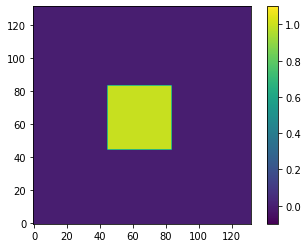

In [5]:
nz = 64
nx, ny = 128, 128
nhalo = 2

domain= (nx, ny, nz)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)

T_ic = lambda i, j, k: (np.abs(i - nx//2) < 20).astype(int) + (np.abs(j - ny//2) < 20).astype(int) == 2

T_data = np.fromfunction(T_ic, shape, dtype=float).astype(float)
plt.imshow(T_data[:,:,0], origin='lower', vmin=-0.1, vmax=1.1)
plt.colorbar()

T_in = gt4py.storage.from_array(
    data=T_data, backend=backend, default_origin=(nhalo, nhalo, 0), shape=shape
)
T_out = copy.deepcopy(T_in)

### Run the computation

We define a timeloop with a given number of iterations (applications of the diffusion stencil and update of the field).

In [6]:
def timeloop(T_in, T_out, dx, dt, alpha, nt):
    for it in range(nt):
        apply_diffusion(T_in, T_out, dx, dt, alpha, domain=domain)
        T_in, T_out = T_out, T_in
        
dx = 1.0
dt = 1.0
alpha = 0.02
nt = 100

In [7]:
%%timeit -n 1 -r 3
timeloop(T_in, T_out, dx=dx, dt=dt, alpha=-alpha, nt=nt)

2.09 s ± 131 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Display result and validate

Plot the results with different backends and check that the results are the same.

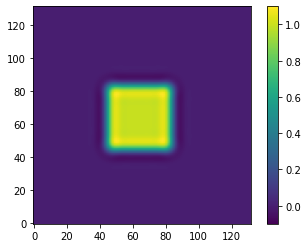

In [8]:
if backend == 'numpy':
    T_ref = copy.deepcopy(T_in)
    
plt.imshow(T_in.data[:,:,0], origin='lower', vmin=-0.1, vmax=1.1);
plt.colorbar();

if 'T_ref' in vars() and backend is 'gt':
    assert not np.any( np.abs( T_in[:,:,0] - T_ref[:,:,0] ) > 0.0)